In [36]:
import xarray as xr
import numpy as np
import pandas as pd
import os
import re
import datetime
import matplotlib.pyplot as plt
import geopandas as gpd
import regionmask
import matplotlib.colors as colors

In [37]:
os.environ['HDF5_USE_FILE_LOCKING']='FALSE'

In [38]:
df = xr.open_dataset('/home/yhuang21/data/MASCON/data/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06.1_V3/GRCTellus.JPL.200204_202304.GLO.RL06.1M.MSCNv03CRI.nc')

In [39]:
df

<xarray.Dataset>
Dimensions:        (lon: 720, lat: 360, time: 220, bounds: 2)
Coordinates:
  * lon            (lon) float64 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * lat            (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time           (time) datetime64[ns] 2002-04-17T12:00:00 ... 2023-04-16
Dimensions without coordinates: bounds
Data variables:
    lwe_thickness  (time, lat, lon) float64 ...
    uncertainty    (time, lat, lon) float64 ...
    lat_bounds     (lat, bounds) float64 ...
    lon_bounds     (lon, bounds) float64 ...
    time_bounds    (time, bounds) datetime64[ns] ...
    land_mask      (lat, lon) float64 ...
    scale_factor   (lat, lon) float64 ...
    mascon_ID      (lat, lon) float64 ...
Attributes: (12/53)
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         JPL GRACE and GRACE-FO MASCON RL06.1Mv03 CRI
    summary:                       Monthly gravity solutions from GRACE and G...
    keywords:                      Solid Earth, Geodetics/Gravity, Gravity, l...
    ...                            ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...
    journal_reference:             Watkins, M. M., D. N. Wiese, D.-N. Yuan, C...
    CRI_filter_journal_reference:  Wiese, D. N., F. W. Landerer, and M. M. Wa...
    date_created:                  2023-06-28T21:06:45Z

In [40]:
selected_time = '2023-04-16T00:00:00.000000000'

In [41]:
# Extract the data at the specific time
data_at_time = df.sel(time=selected_time)

# Create a new data variable 'lwe_thickness_scaled' which is lwe_thickness times scale_factor
data_at_time['lwe_thickness_scaled'] = data_at_time['lwe_thickness'] * data_at_time['scale_factor']

In [42]:
crb_shapefile = gpd.read_file('/home/yhuang21/data/Aqueduct_river_basins_COLORADO RIVER (PACIFIC OCEAN)/Aqueduct_river_basins_COLORADO RIVER (PACIFIC OCEAN).shp')


/home/yhuang21/.local/lib/python3.11/site-packages/regionmask/core/mask.py:166: FutureWarning: Passing 'lon_name' and 'lat_name' is deprecated. Please pass the lon and lat coordinates direcly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(


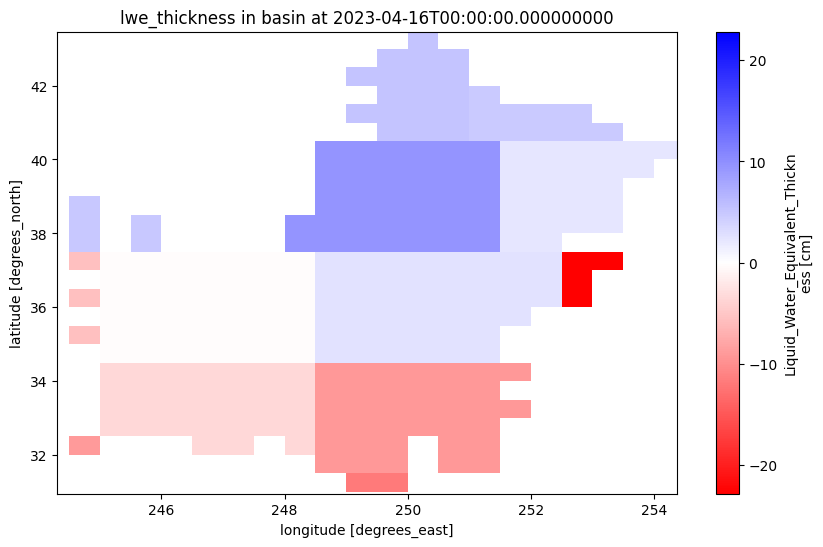

In [43]:
# Create a mask for the shapefile region
basin_regions = regionmask.Regions(name='basin', numbers=[0], names=['basin'], abbrevs=['basin'], outlines=[crb_shapefile.geometry.unary_union])

# Create a mask using the new 'basin_regions'
mask = basin_regions.mask(data_at_time['lwe_thickness'], lat_name='lat', lon_name='lon')

# Mask the lwe_thickness data
masked_data = data_at_time['lwe_thickness'].where(mask.notnull())  # keep data where mask is not null

# Get the bounds of the shapefile
bounds = crb_shapefile.total_bounds

# Create a colormap for positive and negative values
cmap = colors.LinearSegmentedColormap.from_list("", ["red","white","blue"])

# Get the min, max and mean of the data
vmin = masked_data.min()
vmax = masked_data.max()

# Create a normalizer using the TwoSlopeNorm class
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Plot the masked data
fig, ax = plt.subplots(figsize=(10, 6))
masked_data.plot(ax=ax, cmap=cmap)

ax.set_xlim([360 + bounds[0], 360 + bounds[2]])  # setting x limits to min and max of longitude
ax.set_ylim([bounds[1], bounds[3]])

plt.title('lwe_thickness in basin at ' + selected_time)
plt.show()


In [ ]:
# Create a mask for the shapefile region
basin_regions = regionmask.Regions(name='basin', numbers=[0], names=['basin'], abbrevs=['basin'], outlines=[crb_shapefile.geometry.unary_union])

# Create a mask using the new 'basin_regions'
mask = basin_regions.mask(data_at_time['lwe_thickness_scaled'], lat_name='lat', lon_name='lon')

# Mask the lwe_thickness data
masked_data = data_at_time['lwe_thickness_scaled'].where(mask.notnull())  # keep data where mask is not null

# Get the bounds of the shapefile
bounds = crb_shapefile.total_bounds

# Create a colormap for positive and negative values
cmap = colors.LinearSegmentedColormap.from_list("", ["red","white","blue"])

# Get the min, max and mean of the data
vmin = masked_data.min()
vmax = masked_data.max()

# Create a normalizer using the TwoSlopeNorm class
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Plot the masked data
fig, ax = plt.subplots(figsize=(10, 6))
masked_data.plot(ax=ax, cmap=cmap)

ax.set_xlim([360 + bounds[0], 360 + bounds[2]])  # setting x limits to min and max of longitude
ax.set_ylim([bounds[1], bounds[3]])

plt.title('lwe_thickness in basin at ' + selected_time)
plt.show()